In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:10
🔁 Restarting kernel...


In [1]:
%%time
!conda install alignn chgnet matgl pytorch torchvision torchaudio pytorch-cuda -c pytorch -c nvidia -y --quiet

Channels:
 - pytorch
 - nvidia
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

# All requested packages already installed.

CPU times: user 433 ms, sys: 52.7 ms, total: 486 ms
Wall time: 1min 1s


In [2]:
!git clone https://github.com/ACEsuit/mace.git

fatal: destination path 'mace' already exists and is not an empty directory.


In [47]:
pip install ./mace

Processing ./mace
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mace-torch: filename=mace_torch-0.3.5-py3-none-any.whl size=115005 sha256=11ab1a03401c543c4f79395cb2eaf5b725bca2ef7bc90849db71240284a3bf13
  Stored in directory: /tmp/pip-ephem-wheel-cache-hf5hb6sh/wheels/df/5f/32/ef59561725170a81c728fd01c75e56a9ee83bad6da485fc6a5
Successfully built mace-torch
  Attempting uninstall: mace-torch
    Found existing installation: mace-torch 0.3.5
    Uninstalling mace-torch-0.3.5:
      Successfully uninstalled mace-torch-0.3.5


In [4]:
pip install phonopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 18.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for phonopy: filename=phonopy-2.24.3-cp310-cp310-linux_x86_64.whl size=441814 sha256=6b56ecb2cc55906cdf0d3d8f8767757ef5b48c698d96dfaa4861069e66d81098
  Stored in directory: /root/.cache/pip/wheels/06/19/05/d7a3eb0e931ba099cb77dcf23ddbe0223a480d23ef5ad9262e
Successfully built phonopy


In [20]:
import alignn
import matgl
import chgnet
import mace

In [43]:
from jarvis.db.figshare import data, get_jid_data
from jarvis.core.atoms import Atoms
from jarvis.io.vasp.inputs import Poscar
#ids = ['JVASP-1002', 'JVASP-1174', 'JVASP-30']
ids = ['JVASP-1002']
indices_list = [[1, 0, 0],[1, 1, 1],[1,1,0],[0,1,1],[0,0,1],[0,1,0]]
def get_atoms(jid):
    dat = get_jid_data(jid=jid, dataset="dft_3d")
    return Atoms.from_dict(dat["atoms"])

In [22]:
from ase.optimize.fire import FIRE
from ase.constraints import ExpCellFilter
from jarvis.core.atoms import ase_to_atoms
from matgl.ext.ase import M3GNetCalculator
from alignn.ff.ff import AlignnAtomwiseCalculator, wt10_path
from chgnet.model.dynamics import CHGNetCalculator
from mace.calculators import mace_mp

def setup_calculator(calculator_type):
    if calculator_type == "M3GNet":
        pot = matgl.load_model("M3GNet-MP-2021.2.8-PES")
        return M3GNetCalculator(pot)
    elif calculator_type == "ALIGNN-FF":
        model_path = wt10_path()
        return AlignnAtomwiseCalculator(path=model_path)
    elif calculator_type == "CHGNet":
        return CHGNetCalculator()
    elif calculator_type == "MACE":
        return mace_mp()
    else:
        raise ValueError("Unsupported calculator type")


In [41]:
def relax_structure(atoms, calculator_type, fmax=0.01):
    ase_atoms = atoms.ase_converter()
    calc = setup_calculator(calculator_type)
    ase_atoms.calc = calc
    ase_atoms = ExpCellFilter(ase_atoms)
    dyn = FIRE(ase_atoms)
    dyn.run(fmax=fmax)
    relaxed_atoms = ase_to_atoms(ase_atoms)
    return relaxed_atoms


In [42]:
import os
from jarvis.io.vasp.inputs import Poscar

def load_relaxed_atoms(jid, calculator_type):
    poscar_file = f'POSCAR_{jid}_relaxed_{calculator_type}.vasp'
    if not os.path.exists(poscar_file):
        raise FileNotFoundError(f"{poscar_file} not found. Ensure the structure has been relaxed.")
    poscar = Poscar.from_file(poscar_file)
    return poscar.atoms


In [25]:
import numpy as np
from ase.eos import EquationOfState
from ase.units import kJ
import matplotlib.pyplot as plt

def ev_curve(
    atoms=None,
    dx=np.arange(-0.05, 0.05, 0.01),
    calculator=None,
    on_relaxed_struct=False,
    stress_wt=1,
):
    """Get EV curve."""
    relaxed = atoms

    y = []
    vol = []
    for i in dx:
        s1 = relaxed.strain_atoms(i)
        ase_atoms = s1.ase_converter()
        ase_atoms.calc = calculator
        energy = ase_atoms.get_potential_energy()
        y.append(energy)
        vol.append(s1.volume)
    x = np.array(dx)
    y = np.array(y)
    eos = EquationOfState(vol, y, eos="murnaghan")
    v0, e0, B = eos.fit()
    kv = B / kJ * 1.0e24  # , 'GPa')
    print("Energies:", y)
    print("Volumes:", vol)
    return x, y, eos, kv

def calculate_ev_curve(atoms, calculator, dx=np.arange(-0.05, 0.05, 0.01)):
    return ev_curve(atoms=atoms, dx=dx, calculator=calculator)



In [26]:
import numpy as np
from phonopy import Phonopy
from phonopy.file_IO import write_FORCE_CONSTANTS
from jarvis.core.kpoints import Kpoints3D as Kpoints
from ase import Atoms as AseAtoms
def phonons(
    atoms=None,
    calculator=None,
    dim=[5, 5, 5],
    freq_conversion_factor=33.3566830,  # Thz to cm-1
    phonopy_bands_figname="phonopy_bands.png",
    write_fc=False,
    min_freq_tol=-0.05,
    distance=0.2,
):
    """Make Phonon calculation setup."""
    if atoms is None or calculator is None:
        raise ValueError("Atoms and calculator must be provided")

    kpoints = Kpoints().kpath(atoms, line_density=5)
    bulk = atoms.phonopy_converter()
    phonon = Phonopy(bulk, [[dim[0], 0, 0], [0, dim[1], 0], [0, 0, dim[2]]])
    phonon.generate_displacements(distance=distance)
    supercells = phonon.get_supercells_with_displacements()
    set_of_forces = []
    for scell in supercells:
        ase_atoms = AseAtoms(
            symbols=scell.symbols,
            positions=scell.positions,
            cell=scell.cell,
            pbc=True,
        )
        ase_atoms.calc = calculator
        forces = np.array(ase_atoms.get_forces())
        drift_force = forces.sum(axis=0)
        for force in forces:
            force -= drift_force / forces.shape[0]
        set_of_forces.append(forces)

    phonon.produce_force_constants(forces=set_of_forces)
    if write_fc:
        write_FORCE_CONSTANTS(
            phonon.get_force_constants(), filename="FORCE_CONSTANTS"
        )

    lbls = kpoints.labels
    lbls_ticks = []
    freqs = []
    tmp_kp = []
    lbls_x = []
    count = 0
    for ii, k in enumerate(kpoints.kpts):
        k_str = ",".join(map(str, k))
        if ii == 0:
            tmp = []
            for i, freq in enumerate(phonon.get_frequencies(k)):
                tmp.append(freq)
            freqs.append(tmp)
            tmp_kp.append(k_str)
            lbl = "$" + str(lbls[ii]) + "$"
            lbls_ticks.append(lbl)
            lbls_x.append(count)
            count += 1
        elif k_str != tmp_kp[-1]:
            tmp_kp.append(k_str)
            tmp = []
            for i, freq in enumerate(phonon.get_frequencies(k)):
                tmp.append(freq)
            freqs.append(tmp)
            lbl = lbls[ii]
            if lbl != "":
                lbl = "$" + str(lbl) + "$"
                lbls_ticks.append(lbl)
                lbls_x.append(count)
            count += 1

    freqs = np.array(freqs)
    freqs = freqs * freq_conversion_factor
    the_grid = plt.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.0)
    plt.rcParams.update({"font.size": 18})
    plt.figure(figsize=(10, 5))
    plt.subplot(the_grid[0])
    for i in range(freqs.shape[1]):
        plt.plot(freqs[:, i], lw=2, c="b")
    for i in lbls_x:
        plt.axvline(x=i, c="black")
    plt.xticks(lbls_x, lbls_ticks)
    plt.ylabel("Frequency (cm$^{-1}$)")
    plt.xlim([0, max(lbls_x)])

    phonon.run_mesh([40, 40, 40], is_gamma_center=True, is_mesh_symmetry=False)
    phonon.run_total_dos()
    tdos = phonon._total_dos
    freqs, ds = tdos.get_dos()
    freqs = np.array(freqs)
    freqs = freqs * freq_conversion_factor
    min_freq = min_freq_tol * freq_conversion_factor
    max_freq = max(freqs)
    plt.ylim([min_freq, max_freq])

    plt.subplot(the_grid[1])
    plt.fill_between(
        ds, freqs, color=(0.2, 0.4, 0.6, 0.6), edgecolor="k", lw=1, y2=0
    )
    plt.xlabel("DOS")
    plt.yticks([])
    plt.xticks([])
    plt.ylim([min_freq, max_freq])
    plt.xlim([0, max(ds)])
    plt.tight_layout()
    plt.savefig(phonopy_bands_figname)
    plt.show()
    plt.close()

    return phonon


In [27]:
def relax_defect_structure(atoms, calculator_type, fmax=0.05):
    ase_atoms = atoms.ase_converter()
    calculator = setup_calculator(calculator_type)
    ase_atoms.calc = calculator
    ase_atoms = ExpCellFilter(ase_atoms,constant_volume=True)
    dyn = FIRE(ase_atoms)
    dyn.run(fmax=fmax)
    relaxed_atoms = ase_to_atoms(ase_atoms)
    return relaxed_atoms

In [35]:
def relax_surface_structure(atoms, calculator_type, fmax=0.05):
    ase_atoms = atoms.ase_converter()
    calculator = setup_calculator(calculator_type)
    ase_atoms.calc = calculator
    ase_atoms = ExpCellFilter(ase_atoms,constant_volume=True)
    dyn = FIRE(ase_atoms)
    dyn.run(fmax=fmax)
    relaxed_atoms = ase_to_atoms(ase_atoms)
    return relaxed_atoms

In [33]:
import numpy as np
from ase import units
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.nvtberendsen import NVTBerendsen
from jarvis.core.atoms import ase_to_atoms, Atoms
from ase.io import write
from mace.calculators import mace_mp

def get_supercell_dims(atoms, target_atoms=200):
    n_atoms = len(atoms.elements)  # Correct way to get the number of atoms in JARVIS Atoms object
    scale = np.ceil((target_atoms / n_atoms) ** (1/3))
    return [int(scale)] * 3

def general_melter(jid='', atoms=None, calculator=None):
    if atoms is None or calculator is None:
        raise ValueError("Atoms and calculator must be provided")

    dim = get_supercell_dims(atoms)
    sup = atoms.make_supercell_matrix(dim)

    ase_atoms = sup.ase_converter()
    ase_atoms.calc = calculator

    dt = 1 * units.fs
    temp0, nsteps0 = 2000, 5 #2000
    temp1, nsteps1 = 300, 5 #2000
    taut = 20 * units.fs
    trj = jid + '_melt.traj'

    MaxwellBoltzmannDistribution(ase_atoms, temp0 * units.kB)
    dyn = NVTBerendsen(ase_atoms, dt, temp0, taut=taut, trajectory=trj)

    def myprint():
        print(f'time={dyn.get_time() / units.fs: 5.0f} fs ' +
              f'T={ase_atoms.get_temperature(): 3.0f} K')

    dyn.attach(myprint, interval=20)
    dyn.run(nsteps0)


    dyn.set_temperature(temp1)
    dyn.run(nsteps1)


    final_atoms = ase_to_atoms(ase_atoms)
    write(f'POSCAR_{jid}_quenched_{calculator_type}.vasp', final_atoms.ase_converter(), format='vasp')
    return final_atoms

Processing with calculator: CHGNet
CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cpu
Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
Initial atoms for JVASP-1002: System
1.0
3.3641499856336465 -2.5027128e-09 1.94229273881412
1.121382991333525 3.1717517190189715 1.9422927388141193
-2.5909987e-09 -1.8321133e-09 3.884586486670313
Si 
2 
direct
0.8750000000000001 0.875 0.875 Si
0.12499999999999999 0.125 0.12500000000000003 Si

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cpu
      Step     Time          Energy          fmax
FIRE:    0 20:36:35      -10.625703        0.219452
FIRE:    1 20:36:35      -10.626833        0.127127
FIRE:    2 20:36:35      -10.627651        0.015380


<ipython-input-41-9a1a5de52620>:6: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


FIRE:    3 20:36:35      -10.626562        0.216669
FIRE:    4 20:36:35      -10.626886        0.180128
FIRE:    5 20:36:35      -10.627337        0.118155
FIRE:    6 20:36:35      -10.627632        0.033616
FIRE:    7 20:36:35      -10.627596        0.044540
FIRE:    8 20:36:35      -10.627603        0.043280
FIRE:    9 20:36:35      -10.627610        0.040739
FIRE:   10 20:36:35      -10.627617        0.036896
FIRE:   11 20:36:36      -10.627626        0.031759
FIRE:   12 20:36:36      -10.627642        0.025379
FIRE:   13 20:36:36      -10.627649        0.017836
FIRE:   14 20:36:36      -10.627657        0.009319
Relaxed structure for JVASP-1002: System
1.0
3.3447527457649406 4.7188207709251043e-07 1.9310936422879141
1.1149177026493757 3.1534631195103127 1.9310936271261006
2.2840024735634623e-07 1.429340018481644e-07 3.8621878877371207
Si 
2 
direct
0.8800736718779998 0.8800751889041377 0.8800754720299883 Si
0.12572451605390605 0.1257247890426791 0.12572509636251075 Si

Energies: [-

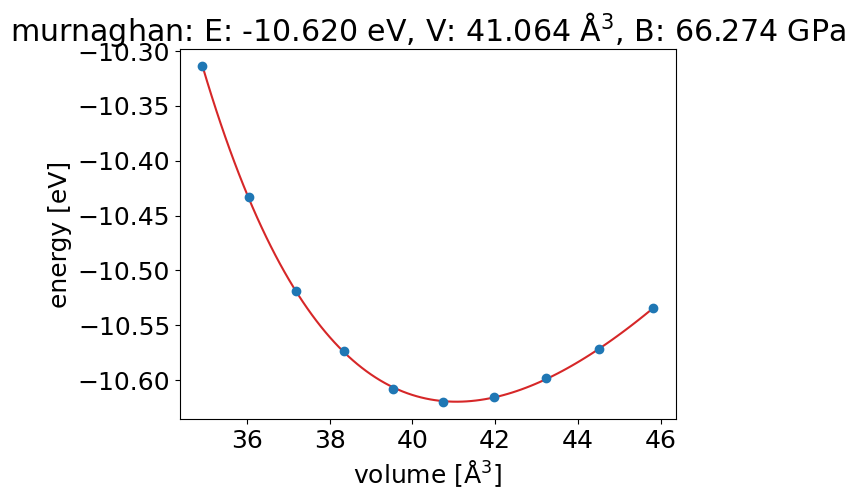

<Figure size 640x480 with 0 Axes>

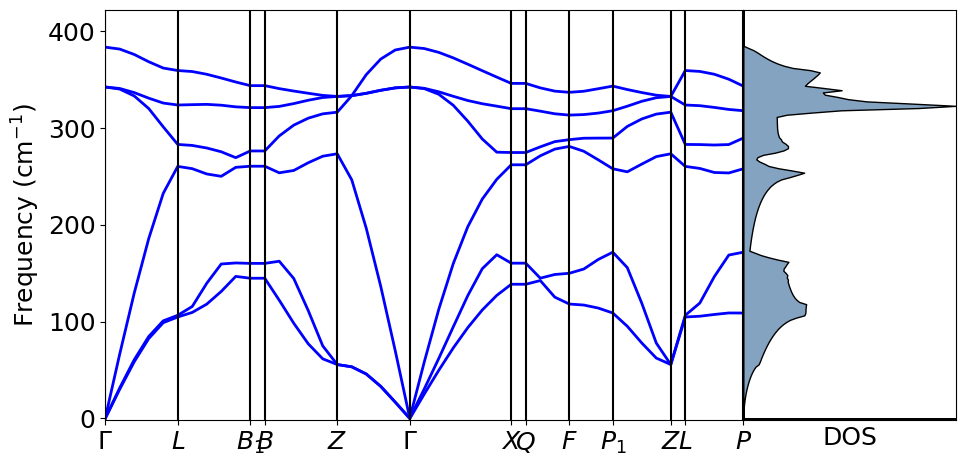

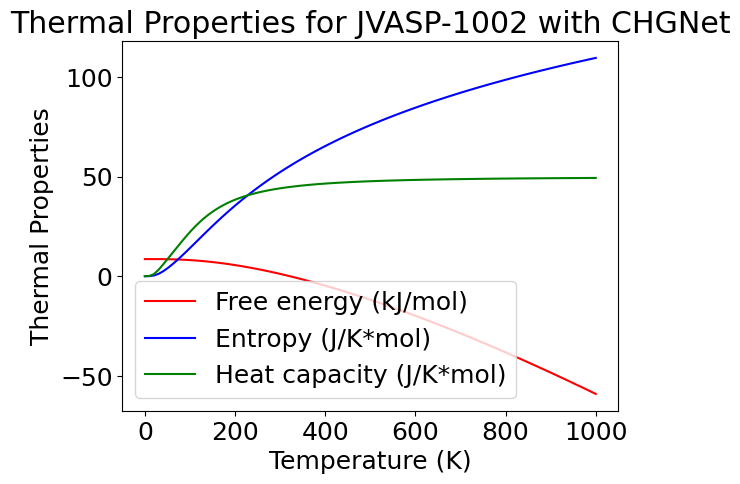

Zero-point energy for JVASP-1002 with CHGNet: 0.08891297108192855 eV
CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cpu


/usr/local/lib/python3.10/site-packages/ase/md/md.py:53: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


time=    0 fs T= 2062 K
Quenched structure for JVASP-1002: System
1.0
16.72376 0.0 9.65547
5.57459 15.76732 9.65547
0.0 0.0 19.31094
Si 
250 
direct
0.17604080897287183 0.17279205013620375 0.17661289608744216 Si
0.1669633057474905 0.18582962460016694 0.3811344144049909 Si
0.17168670463787958 0.17096004940593112 0.57868587211571 Si
0.18313474327393228 0.17286698247554705 0.7726426099743192 Si
0.17578080752157596 0.17389913571447116 0.9758124353200875 Si
0.16671830682166927 0.38353679606459784 0.17675065392097344 Si
0.17430821976469665 0.37919884630130524 0.3676309230919254 Si
0.17656969243026346 0.3764732960725011 0.5675267368353597 Si
0.1789304823764542 0.3758173634160522 0.7744262492371647 Si
0.17282782819316322 0.37164525935695325 0.9805387493882789 Si
0.18295326855890315 0.5770181773310079 0.16625058569417764 Si
0.1793341194779196 0.5773909051544787 0.36588580869680476 Si
0.17616232144043822 0.5795668401513882 0.5697257481693803 Si
0.17891425889315993 0.5749294017393417 0.7686403141

<ipython-input-27-102a9848b5ac>:5: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms,constant_volume=True)


      Step     Time          Energy          fmax
FIRE:    0 20:37:33     -333.801418        0.184973
FIRE:    1 20:37:34     -333.803191        0.176223
FIRE:    2 20:37:34     -333.806375        0.160800
FIRE:    3 20:37:35     -333.810310        0.144029
FIRE:    4 20:37:36     -333.814276        0.126077
FIRE:    5 20:37:37     -333.817400        0.623359
FIRE:    6 20:37:38     -333.798925        3.512276
FIRE:    7 20:37:38     -333.813525        2.199358
FIRE:    8 20:37:39     -333.818662        1.267768
FIRE:    9 20:37:40     -333.821125        0.203916
FIRE:   10 20:37:40     -333.821125        0.182432
FIRE:   11 20:37:40     -333.821185        0.141901
FIRE:   12 20:37:41     -333.821215        0.086676
FIRE:   13 20:37:41     -333.821275        0.083018
FIRE:   14 20:37:42     -333.821305        0.082923
FIRE:   15 20:37:42     -333.821305        0.084902
FIRE:   16 20:37:42     -333.821335        0.113683
FIRE:   17 20:37:43     -333.821395        0.119940
FIRE:   18 20:

In [51]:
import os
import matplotlib.pyplot as plt
from jarvis.analysis.defects.vacancy import Vacancy
from jarvis.analysis.defects.surface import Surface
#calculator_types = ["M3GNet","CHGNet","MACE","ALIGNN-FF"]
calculator_types = ["CHGNet"]


for calculator_type in calculator_types:
    print(f"Processing with calculator: {calculator_type}")
    calculator = setup_calculator(calculator_type)
    for jid in ids:
        atoms = get_atoms(jid)
        print(f'Initial atoms for {jid}:', atoms)
        relaxed_atoms = relax_structure(atoms, calculator_type)
        print(f'Relaxed structure for {jid}:', relaxed_atoms)


        poscar = Poscar(atoms=relaxed_atoms)
        poscar.write_file(f'POSCAR_{jid}_relaxed_{calculator_type}.vasp')
        saved_relaxed_atoms = load_relaxed_atoms(jid, calculator_type)
        %matplotlib inline
        # Calculate EV curve
        x, y, eos, kv = calculate_ev_curve(saved_relaxed_atoms, calculator)
        print(f"Bulk modulus for {jid}: {kv} GPa")
        plt.figure()
        eos.plot(show=True)
        plt.savefig(f"E_vs_V_{jid}_{calculator_type}.png")
        plt.show()


        phonon = phonons(atoms=saved_relaxed_atoms, calculator=calculator)

        phonon.run_mesh(mesh=[20, 20, 20])
        phonon.run_thermal_properties(t_step=10, t_max=1000, t_min=0)
        tprop_dict = phonon.get_thermal_properties_dict()

        plt.figure()
        plt.plot(tprop_dict['temperatures'], tprop_dict['free_energy'], label='Free energy (kJ/mol)', color='red')
        plt.plot(tprop_dict['temperatures'], tprop_dict['entropy'], label='Entropy (J/K*mol)', color='blue')
        plt.plot(tprop_dict['temperatures'], tprop_dict['heat_capacity'], label='Heat capacity (J/K*mol)', color='green')
        plt.legend()
        plt.xlabel('Temperature (K)')
        plt.ylabel('Thermal Properties')
        plt.title(f'Thermal Properties for {jid} with {calculator_type}')
        plt.savefig(f"Thermal_Properties_{jid}_{calculator_type}.png")
        plt.show()
        zpe = tprop_dict['free_energy'][0] * 0.0103643  # converting from kJ/mol to eV
        print(f"Zero-point energy for {jid} with {calculator_type}: {zpe} eV")


        quenched_atoms = general_melter(jid=jid, atoms=saved_relaxed_atoms, calculator=setup_calculator(calculator_type))
        print(f'Quenched structure for {jid}:', quenched_atoms)


        strts = Vacancy(atoms).generate_defects(on_conventional_cell=True, enforce_c_size=8, extend=1)
        for j in strts:
            strt = Atoms.from_dict(j.to_dict()['defect_structure'])
            name = f"{jid}_{strt.composition.reduced_formula}_{j.to_dict()['symbol']}_{j.to_dict()['wyckoff_multiplicity']}"
            print('Defect structure:', name)
            pos = Poscar(strt)
            pos.write_file(os.path.join(f"POSCAR_{name}.vasp"))
            relaxed_defect_atoms = relax_defect_structure(strt, calculator_type)
            print(f"Relaxed defect structure for {name}: {relaxed_defect_atoms}")
            pos_relaxed = Poscar(relaxed_defect_atoms)
            pos_relaxed.write_file(os.path.join(f"POSCAR_{name}_relaxed_{calculator_type}.vasp"))

        for indices in indices_list:
            surface = Surface(atoms=atoms, indices=indices, layers=4, vacuum=18).make_surface().center_around_origin()
            if surface.check_polar:
                print(f"Skipping polar surface for {jid} with indices {indices}")
                continue
            poscar_surface = Poscar(atoms=surface)
            poscar_surface.write_file(os.path.join(f"POSCAR_{jid}_surface_{indices}_{calculator_type}.vasp"))
            relaxed_surface_atoms = relax_surface_structure(surface, calculator_type)
            print(f"Relaxed surface structure for {jid} with indices {indices}: {relaxed_surface_atoms}")
            pos_relaxed_surface = Poscar(relaxed_surface_atoms)
            pos_relaxed_surface.write_file(os.path.join(f"POSCAR_{jid}_surface_{indices}_{calculator_type}_relaxed.vasp"))